<a href="https://colab.research.google.com/github/RichardCYC/Bike_sharing_demand_prediction/blob/Delete_wrong_file/Bike_share_prediction_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

**Bike sharing demand prediction**

Project Objective：
Predict bike sharing demand by hour

[Kaggle link](https://www.kaggle.com/c/bike-sharing-demand/overview)



---

**Data Fields**
*   datetime - hourly date + timestamp  
*   season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
*   holiday - whether the day is considered a holiday
*   workingday - whether the day is neither a weekend nor holiday
*   weather - 
    *   1: Clear, Few clouds, Partly cloudy, Partly cloudy
    *   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    *   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    *   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
*   temp - temperature in Celsius
*   atemp - "feels like" temperature in Celsius
*   humidity - relative humidity
*   windspeed - wind speed
*   casual - number of non-registered user rentals initiated
*   registered - number of registered user rentals initiated
*   count - number of total rentals

In [ ]:
# mount google drive to get data
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/Colab_Notebooks') 
os.getcwd() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive/Colab_Notebooks'

In [ ]:
# import module
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # ignore warnings

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [ ]:
# read data(combine training & testing data)
train = pd.read_csv('Bike_share_prediction/train.csv') 
test = pd.read_csv('Bike_share_prediction/test.csv') 
combine = pd.concat([train, test])

# EDA

In [ ]:
# check data 
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.7+ MB


**Finding**

* No missing values
* There are no casual, registered and count values in testing dataset

In [ ]:
combine.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


**Finding**

* We have hourly date + timestamp in "datetime" and we can extract more information such as year and month from "datetime" later.
* "casual" + "registered" = "count". We can check the relationship among them later to decide we should predict "count" directly or predict "casual" and "registered" separately and add up them to get "count".

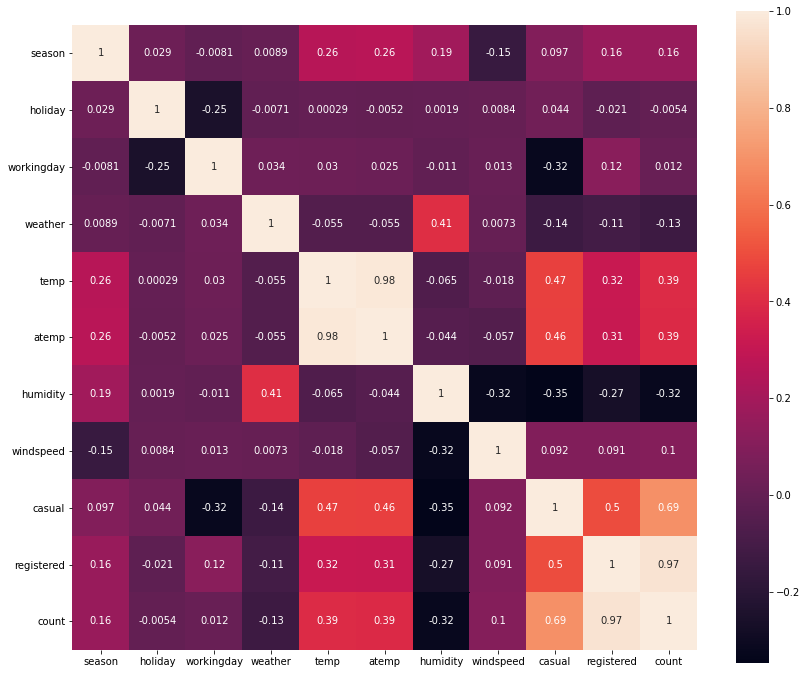

In [ ]:
# use heatmap to see the correlations among features
plt.figure(figsize=(14,12))
sns.heatmap(train.corr(), square=True, annot=True)

**Finding**

* The correlation coefficient between "count" and "registered" is up to 0.96. However, it is only 0.69 between "count" and "casual". The small correlation between "count" and "casual" means we may get more noise if we predict "count" directly without splitting into "casual" and "registered".
* "workingday", "temp" and "humidity" have relatively strong correlation with "casual".
* "temp" and "humidity" have relatively strong correlation with "casual".
* The correlation between "temp" and "atemp" is pretty strong so that we only use one of them as feature if needed.

In [ ]:
# extract time-related information from "datetime"
combine['ymonth'] = combine['datetime'].apply(lambda x:x[0:7])
combine['year'] = combine['datetime'].apply(lambda x:x[0:4])
combine['month'] = combine['datetime'].apply(lambda x:x[5:7])
combine['date'] = combine['datetime'].apply(lambda x:x[8:10])
combine['hour'] = combine['datetime'].apply(lambda x:x[11:13])

In [ ]:
# group three observed columns into a list to iterate them in loop
target = ['count', 'casual', 'registered']

In [ ]:
# set colors for visualiztion
color = ['red', 'blue', 'green']

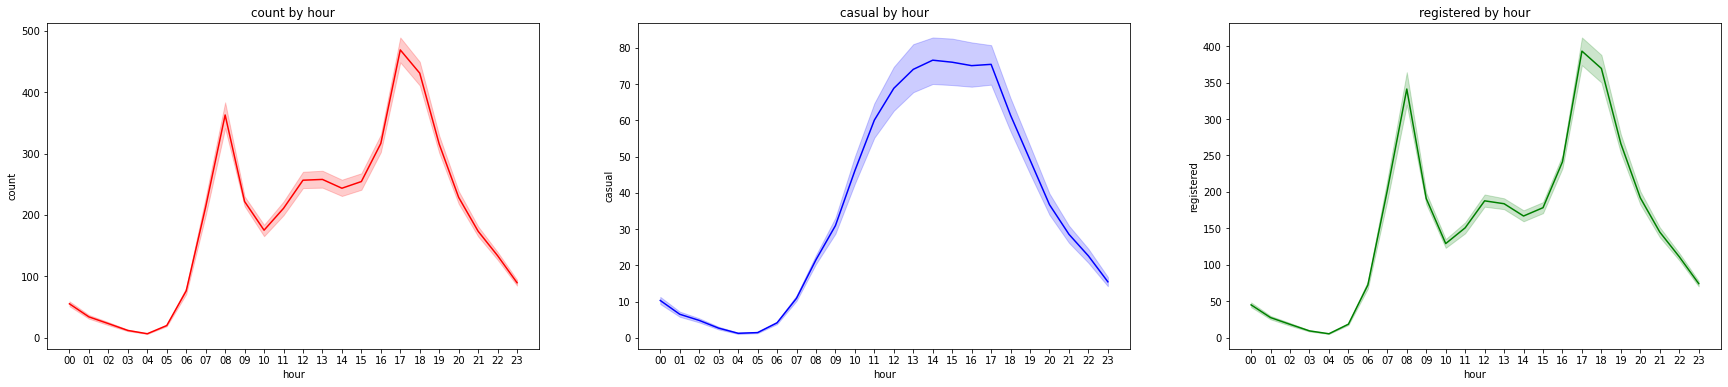

In [ ]:
# see the distribution of target by hour
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.lineplot(x= 'hour', y=tar, data = combine.dropna(), color = col)
  axes[i].set_title(tar+' by hour')

**Finding**

* The distribution of "count" and "registered" is similar as we think.
* Differences among "hour" are obvious in all targets.

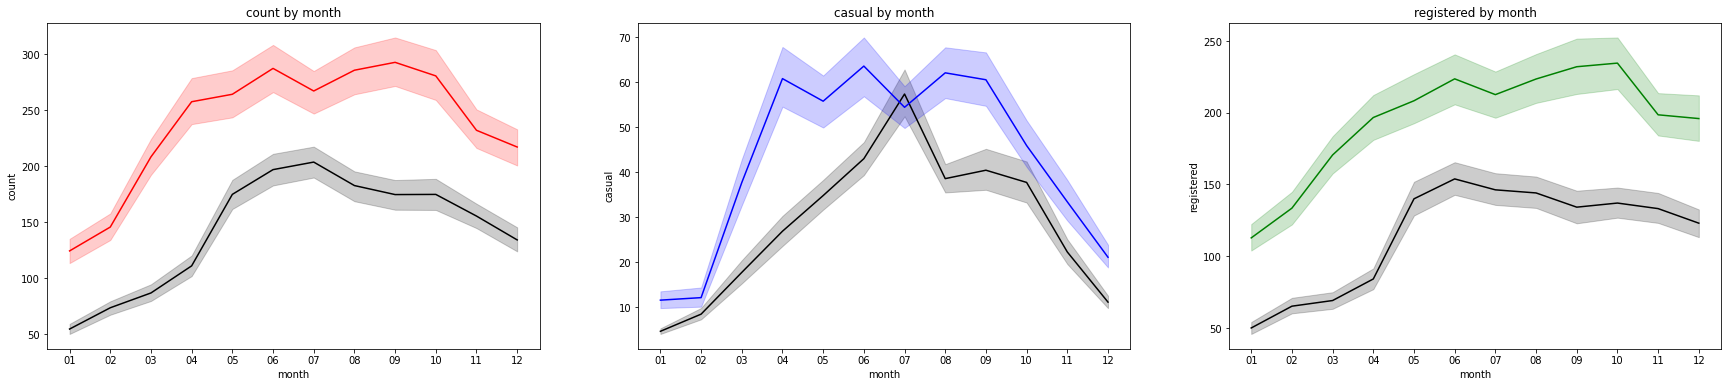

In [ ]:
# see the distribution of target by year and month
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.lineplot(x= 'month', y=tar, data = combine.dropna()[combine.dropna()['year'] == '2011'], color = 'black')
  sns.lineplot(x= 'month', y=tar, data = combine.dropna()[combine.dropna()['year'] == '2012'], color = col)
  axes[i].set_title(tar+' by month')

**Finding**

* Differences between '2011' and '2012' are obvious. We can use add "year" into our model or other time-related data, which can show the growing trend about our targets.
* Differences among "month" are obvious in all targets.

In [ ]:
# create "average target values in last month" to show the growing trend of target
combine_move = combine[['ymonth', 'count', 'casual', 'registered']]
combine_move = combine_move.groupby('ymonth')['count', 'casual', 'registered'].mean().reset_index()\
                            .rename(columns={'count':'precount', 'casual':'precas', 'registered':'prereg'})
combine_move['ymonth'] = combine_move['ymonth'].map(lambda x: str(int(x[:4])+1)+'-01' if x[-2:] =='12' \
                                            else (str(int(x[:4]))+'-'+str(int(x[-2:])+1)) if x[-2:] in ['09', '10', '11'] \
                                            else str(int(x[:4]))+'-0'+str(int(x[-2:])+1))

# fill three new columns with "average target values in 2011-01" for "2011-01"
combine_move = combine_move.append({'ymonth':'2011-01', 'precount':combine_move.iloc[0]['precount'], \
                    'precas':combine_move.iloc[0]['precas'],\
                    'prereg':combine_move.iloc[0]['prereg']}, ignore_index=True)

combine = pd.merge(combine, combine_move)

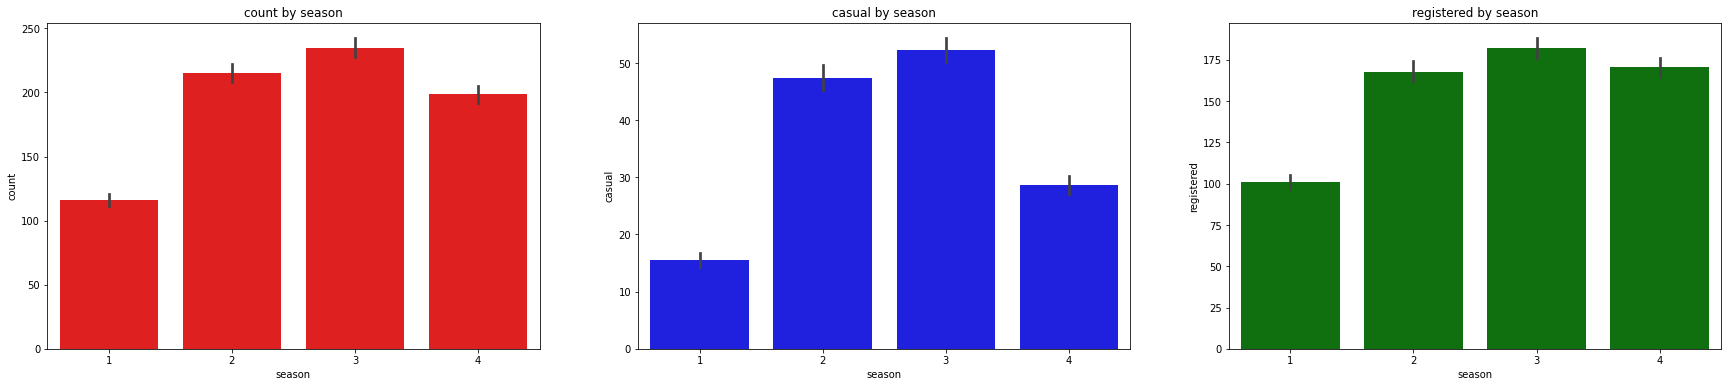

In [ ]:
# see the distribution of target by season
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.barplot(x= 'season', y=tar, data = combine.dropna(), color = col)
  axes[i].set_title(tar+' by season')

**Finding**

* Differences among 4 types of "season" are obvious in "count" and "casual" but not obvious in "registered" except 'season1'. We can create a new column with catorical data to show "season1 or not" for "registered".

In [ ]:
# create a new column with catorical data to show "season 1 or not"
combine['reg_season'] = combine['season'].map(lambda x: 1 if x==1 else 0)

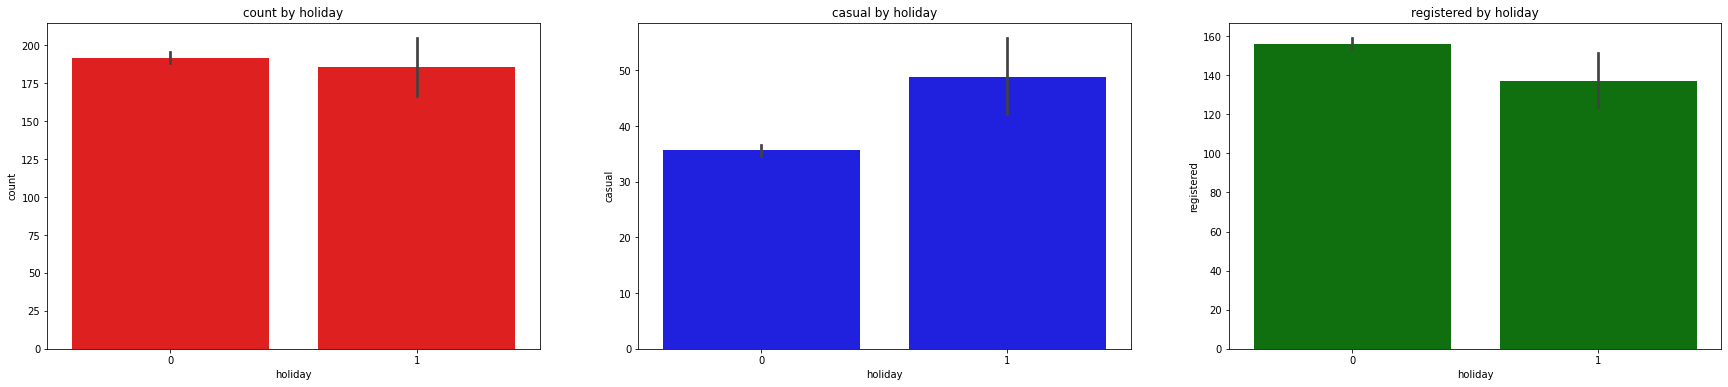

In [ ]:
# see the distribution of target by holiday
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.barplot(x= 'holiday', y=tar, data = combine.dropna(), color = col)
  axes[i].set_title(tar+' by holiday')

**Finding**

* Differences between two types of "holiday" are obvious in "casual" and "registered".

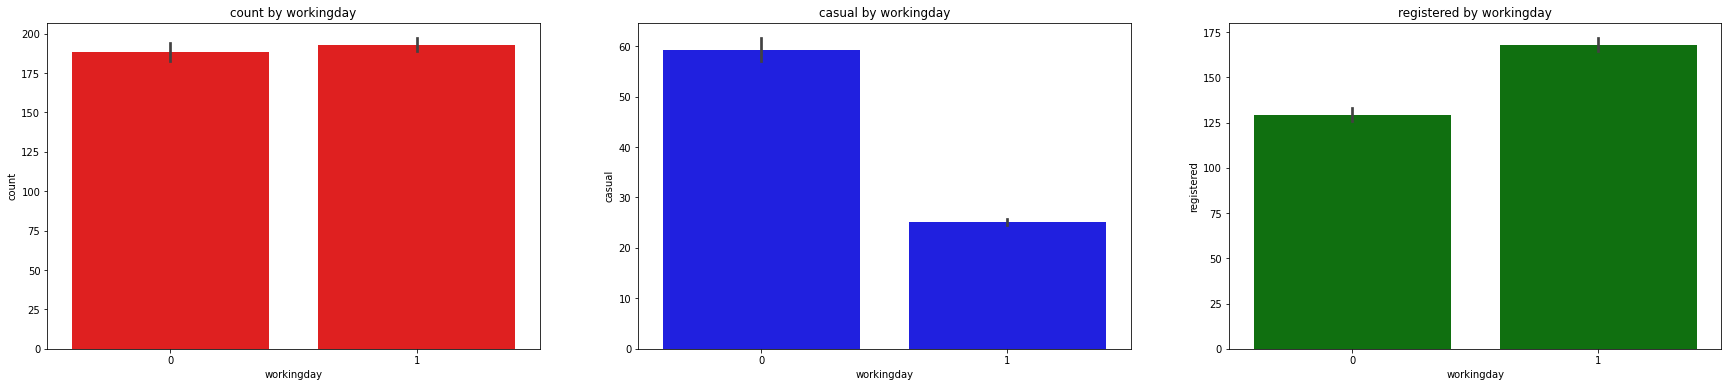

In [ ]:
# see the distribution of target by workingday
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.barplot(x= 'workingday', y=tar, data = combine.dropna(), color = col)
  axes[i].set_title(tar+' by workingday')

**Finding**

* Differences between types of "workingday" are obvious in "casual" and "registered".

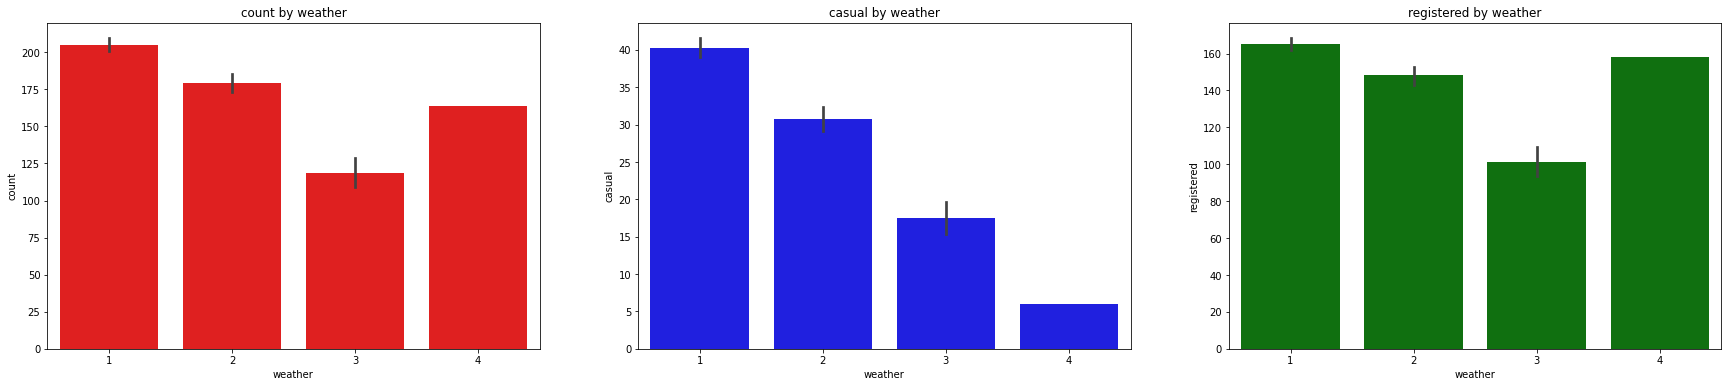

In [ ]:
# see the distribution of target by weather
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.barplot(x= 'weather', y=tar, data = combine.dropna(), color = col)
  axes[i].set_title(tar+' by weather')

**Finding**

* Differences among 4 types of "weather" are obvious in "count" and "casual" but not obvious in "registered" except 'weather3'. We can create a new column with catorical data to show "weather3 or not" for "registered".

In [ ]:
# create a new column with catorical data to show "weather3 or not"
combine['reg_weather'] = combine['weather'].map(lambda x: 1 if x==3 else 0)

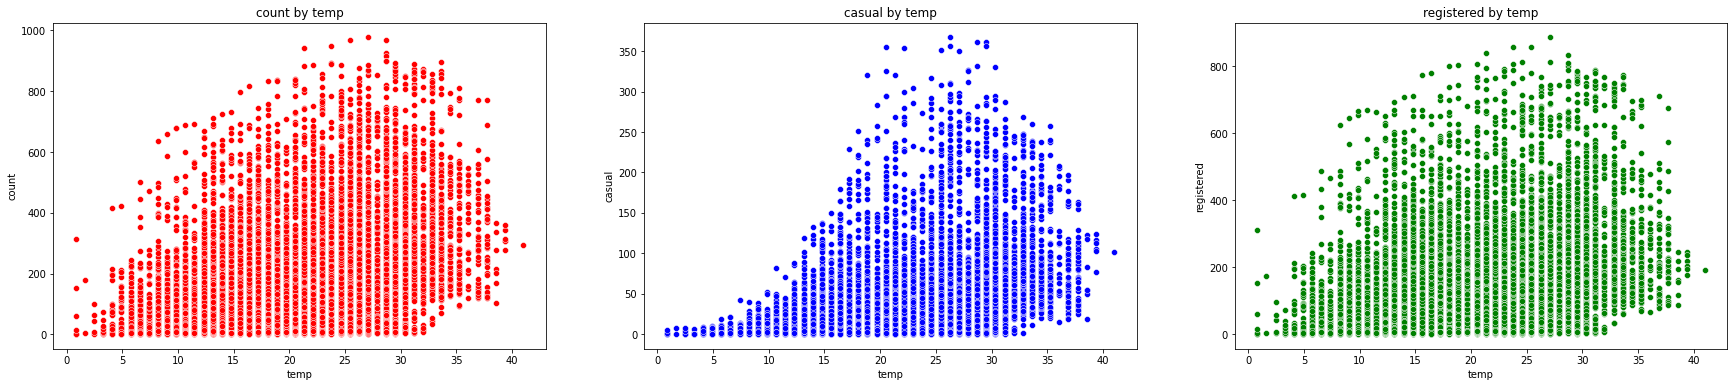

In [ ]:
# see the distribution of target by temp
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.scatterplot(x= 'temp', y=tar, data = combine.dropna(), color = col)
  axes[i].set_title(tar+' by temp')

**Finding**

* Correlation between "casual" and "temp" is relatively strong than others.

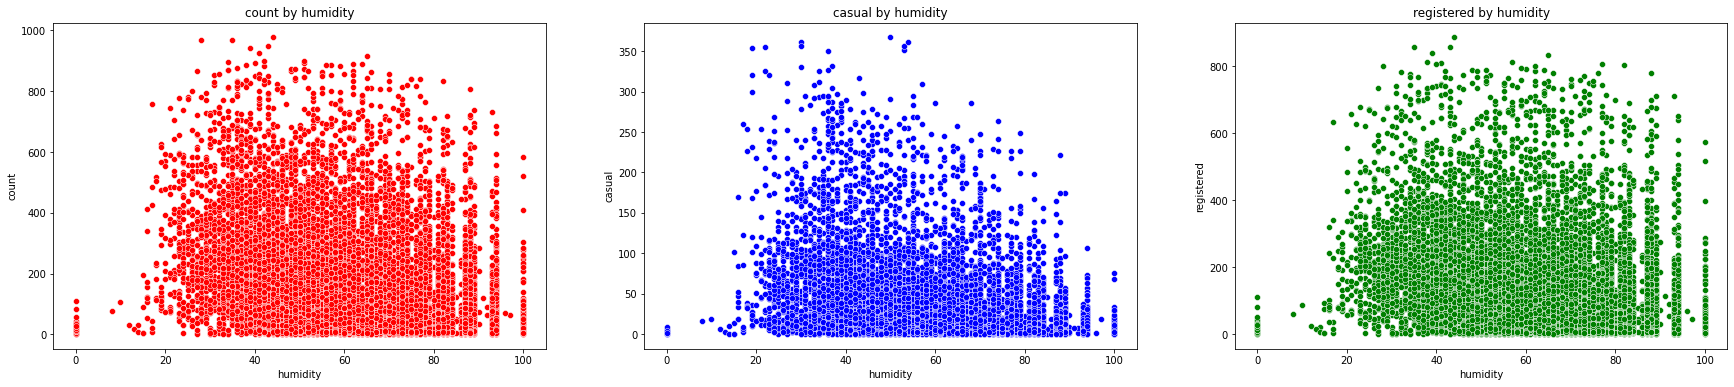

In [ ]:
# see the distribution of target by humidity
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.scatterplot(x= 'humidity', y=tar, data = combine.dropna(), color = col)
  axes[i].set_title(tar+' by humidity')

**Finding**

* Correlation between "casual" and "humidity" is relatively strong than others.

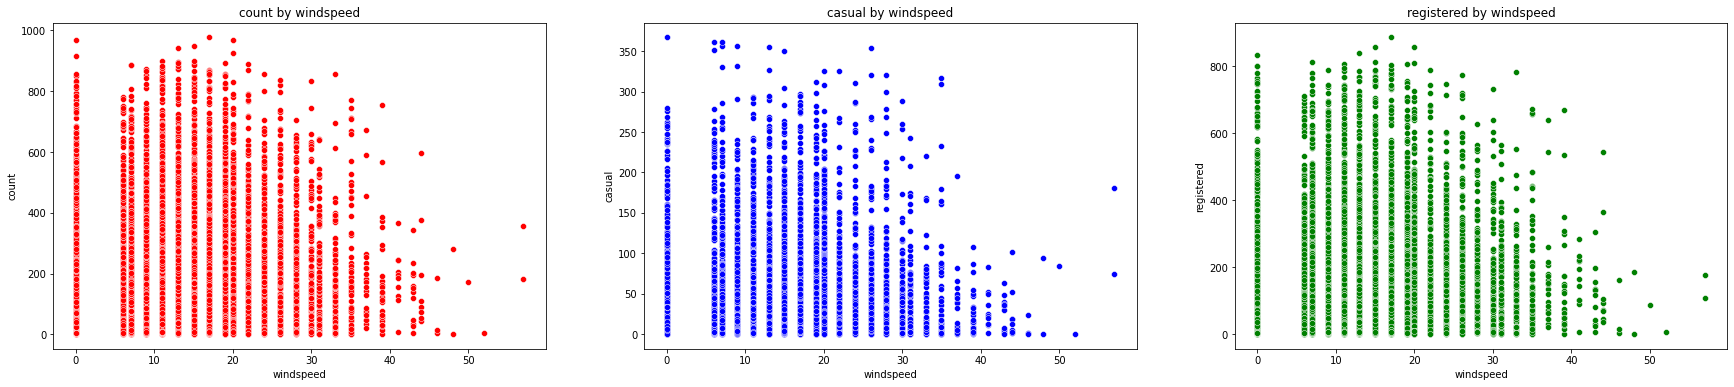

In [ ]:
# see the distribution of target by windspeed
fig, axes = plt.subplots(1,3,figsize=(30,6))
for tar, col, i in zip(target, color, range(3)):
  axes[i] = plt.subplot(1,3,i+1)
  sns.scatterplot(x= 'windspeed', y=tar, data = combine.dropna(), color = col)
  axes[i].set_title(tar+' by windspeed')

**Finding**

* There is no obvious correlation between "windspeed" and all targets.

# Modeling

In [ ]:
# pick useful features
col_cas = ['hour', 'year', 'month', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'precas', 'casual']
col_reg = ['hour', 'year', 'month', 'reg_season', 'holiday', 'workingday', 'reg_weather', 'prereg', 'registered']

In [ ]:
# split training data into training and val(validation)
training = combine[combine['date'].astype('int')<16]
val = combine[(combine['date'].astype('int')>15) & (combine['date'].astype('int')<20)]

In [ ]:
# process training data for modeling
cas_training = training[col_cas]
reg_training = training[col_reg]

x_cas_training = cas_training.drop(columns = ['casual'])
y_cas_training = cas_training['casual']

x_reg_training = reg_training.drop(columns = ['registered'])
y_reg_training = reg_training['registered']

In [ ]:
# setting up parameters for RandomForest
clf_rf = RandomForestClassifier(
    n_estimators=500, \
    max_depth=None, \
    min_samples_split=10)

In [ ]:
# fit model for "casual"
clf_rf_cas = clf_rf.fit(x_cas_training, y_cas_training)

In [ ]:
# use validation data to see how model performs
x_cas_val = val[col_cas].drop(columns = ['casual'])
y_cas_val = val[col_cas]['casual']
cas_predict = clf_rf_cas.predict(x_cas_val)

MSLE = mean_squared_log_error(cas_predict, y_cas_val)
RMSLE = MSLE ** 0.5
print('MSLE = ', MSLE)
print('RMSLE = ', RMSLE)

MSLE =  0.5666556569800906
RMSLE =  0.7527653399168234


In [ ]:
# use all training data to fit model
all_train = combine[combine.casual.notnull()]
x_all_train = all_train[col_cas].drop(columns = ['casual'])
y_all_train = all_train['casual']

clf_rf_cas = clf_rf.fit(x_all_train, y_all_train)

In [ ]:
# predict casual
testing = combine[combine.casual.isnull()]
cas_test = testing[(col_cas[0:len(col_cas)-1])]

cas_predict = clf_rf_cas.predict(cas_test)

In [ ]:
# fit model for "registered"
clf_rf_reg = clf_rf.fit(x_reg_training, y_reg_training)

In [ ]:
# use validation data to see how model performs
x_reg_val = val[col_reg].drop(columns = ['registered'])
y_reg_val = val[col_reg]['registered']
reg_predict = clf_rf_reg.predict(x_reg_val)

MSLE = mean_squared_log_error(reg_predict, y_reg_val)
RMSLE = MSLE ** 0.5
print('MSLE = ', MSLE)
print('RMSLE = ', RMSLE)

MSLE =  0.19494532597661066
RMSLE =  0.441526132835431


In [ ]:
# use all training data to fit model
all_train = combine[combine.casual.notnull()]
x_all_train = all_train[col_reg].drop(columns = ['registered'])
y_all_train = all_train['registered']

clf_rf_reg = clf_rf.fit(x_all_train, y_all_train)

In [ ]:
# predict refistered
reg_test = testing[(col_reg[0:len(col_reg)-1])]
reg_predict = clf_rf_reg.predict(reg_test)

In [ ]:
# get count_predict by adding up cas_predict and reg_predict 
count_predict = cas_predict+reg_predict

# output predictions to csv
submission = test['datetime'].to_frame()
submission['count'] = count_predict
submission.to_csv('Bike_share_prediction/answer_new_v5.csv', index = False)